# Recommendations with IBM

In this notebook, I will be putting your recommendation skills to use on real
data from the IBM Watson Studio platform. 

By following the table of contents, I will build out a number of different
methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
from subprocess import call

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import project_tests as t


In [2]:
df = pd.read_csv('../data/user-item-interactions.csv')
df_content = pd.read_csv('../data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data
print(df.shape)
print(*df.columns)
df.head()

(45993, 3)
article_id title email


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
print(df_content.shape)
print(*df_content.columns)
df_content.head()

(1056, 5)
doc_body doc_description doc_full_name doc_status article_id


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
# The number of times each user interacts with an article.
user_interacts = df[["email", 'article_id']].groupby('email').count()
user_interacts.describe()

,article_id
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


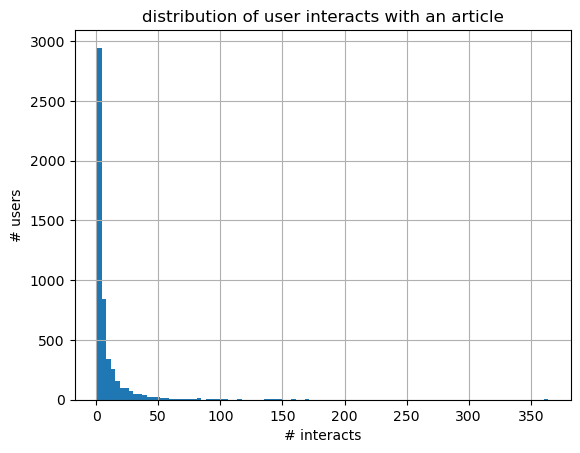

In [6]:
# The distribution of how many articles a user interacts.
user_interacts.hist(bins=100)
plt.title('distribution of user interacts with an article')
plt.xlabel('# interacts')
plt.ylabel('# users')
plt.show()

In [7]:
print(user_interacts.median())
print(user_interacts.max())

article_id    3.0
dtype: float64
article_id    364
dtype: int64


In [8]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

print(f'50% of individuals interact with {median_val} articles or fewer.')
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate articles
duplicated_articles = (
    df_content[df_content.duplicated(subset="article_id")].sum().count()
)
print(f"{duplicated_articles} duplicate articles")


5 duplicate articles


In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates("article_id", keep="first")
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# The number of unique articles that have an interaction with a user. 
df['article_id'].nunique()

714

In [12]:
# The number of unique articles in the dataset (whether they have any interactions or not).
len(df_content['article_id'])

1051

In [13]:
# The number of unique users in the dataset. (excluding null values)
df['email'].nunique()

5148

In [14]:
# The number of user-article interactions in the dataset.
df.shape[0]

45993

In [15]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = len(df_content['article_id']) # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

print(f'{unique_articles} is the number of unique articles that have at least one interaction.')
print(f'{total_articles} is the number of unique articles on the IBM platform.')
print(f'{unique_users} is the number of unique users.')
print(f'{user_article_interactions} is the number of user-article interactions.')

714 is the number of unique articles that have at least one interaction.
1051 is the number of unique articles on the IBM platform.
5148 is the number of unique users.
45993 is the number of user-article interactions.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
df[["email", "article_id"]].groupby("article_id").count().sort_values(
    ascending=False, by="email"
).head(5)


,email
article_id,
1429.0,937
1330.0,927
1431.0,671
1427.0,643
1364.0,627


In [17]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

print(f'The most viewed article in the dataset was the article_id {most_viewed_article_id}')
print(f'The most viewed article in the dataset was viewed {max_views} times.')

The most viewed article in the dataset was the article_id 1429.0
The most viewed article in the dataset was viewed 937 times.


In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
df[["user_id", "title"]].groupby("title").count().sort_values(
    ascending=False, by="user_id"
).head(5)


,user_id
title,
use deep learning for image classification,937
insights from new york car accident reports,927
visualize car data with brunel,671
"use xgboost, scikit-learn & ibm watson machine learning apis",643
predicting churn with the spss random tree algorithm,627


In [21]:
df[["user_id", "article_id"]].groupby("article_id").count().sort_values(
    ascending=False, by="user_id"
).head(5)


,user_id
article_id,
1429.0,937
1330.0,927
1431.0,671
1427.0,643
1364.0,627


In [22]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    """
    # Your code here
    top_articles = (
        df.groupby("title")["user_id"]
        .count()
        .sort_values(ascending=False)
        .head(n)
        .index.to_list()
    )
    
    # Return the top article titles from df (not df_content)
    return top_articles


def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    """
    # Your code here
    top_articles = (
        df.groupby("article_id")["user_id"]
        .count()
        .sort_values(ascending=False)
        .head(n)
        .index.to_list()
    )

    # Return the top article ids
    return top_articles  


In [23]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [24]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [25]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1
    values where a user interacted with an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = pd.crosstab(df['user_id'], df['article_id'])
    user_item[user_item > 0] = 1
    
    # return the user_item matrix 
    return user_item 

user_item = create_user_item_matrix(df)

In [26]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [27]:
def find_similar_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot
    product users) are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered

    """
    # Get user_ids
    user_ids = user_item.index

    # compute similarity of each user to the provided user
    dot_product_matrix = np.dot(user_item.values, user_item.values.T)

    # Convert to DataFrame for better interpretation
    dot_product_df = pd.DataFrame(
        dot_product_matrix, index=user_ids, columns=user_ids
    )

    # Get the similarity scores for the provided user
    user_similarity_scores = dot_product_df[user_id].copy()

    # Remove the provided user from the list (set similarity with itself to -1 or NaN)
    user_similarity_scores.loc[user_id] = -1

    # Sort the users by similarity score in descending order
    sorted_users = user_similarity_scores.sort_values(ascending=False)

    # Get the list of user IDs ordered from most similar to least similar
    most_similar_users = sorted_users.index.tolist()

    # return a list of the users in order from most to least similar
    return most_similar_users  


In [28]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [29]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of
                    article ids (this is identified by the title column)
    """
    # Your code here
    article_names = []
    
    for article_id in article_ids:
        # Convert article_id to float for matching and search in the dataframe
        matched_article = df[df["article_id"] == float(article_id)]
        
        # If title exists, append the title, otherwise append 'Unknown'
        if not matched_article.empty:
            article_names.append(matched_article["title"].values[0])
        else:
            article_names.append('Unknown')

    # Return the article names associated with list of article ids
    return article_names


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the doc_full_name column in df_content)

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Your code here
    # Get article IDs that the user has interacted with (those with 1)
    article_ids = (
        user_item.loc[user_id][user_item.loc[user_id] == 1]
        .index.astype(str)
        .tolist()
    )

    # Get article names based on the article_ids from df_content
    article_names = get_article_names(article_ids)
    
    # return the ids and names
    return article_ids, article_names
    

def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them
    as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily

    """
    # Your code here
    # Find similar users based on closeness
    similar_users = find_similar_users(user_id)

    # Find articles the current user has already seen
    # list of article_ids already seen by user
    seen_articles = set(get_user_articles(user_id)[0])

    recs = []  # List to store recommendations

    # Loop through similar users and gather article recommendations
    for user in similar_users:
        # Get articles seen by this similar user
        user_articles = set(get_user_articles(user)[0])
        
        # Find new articles that the current user hasn't seen yet
        new_recs = list(user_articles - seen_articles)
        
        # Add them to the recommendation list
        recs.extend(new_recs)

        # If we have enough recommendations, stop early
        if len(recs) >= m:
            break

    # Return only 'm' recommendations (if we have more than 'm' recs, slice)
    recs = recs[:m]

    return recs


In [30]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['brunel 2.0 preview',
 'deep learning with data science experience',
 'twelve\xa0ways to color a map of africa using brunel',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'get started with streams designer by following this roadmap',
 '5 practical use cases of social network analytics: going beyond facebook and twitter',
 'why even a moth’s brain is smarter than an ai',
 'times world university ranking analysis',
 'flightpredict ii: the sequel  – ibm watson data lab',
 '54174    detect potentially malfunctioning sensors in r...\nName: title, dtype: object']

In [31]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [32]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    """
    INPUT:
    user_id - (int) the ID of the user
    df - (pandas dataframe) the interactions dataframe containing columns 'user_id' and 'article_id'
    user_item - (pandas dataframe) a matrix of users by articles with 1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) dataframe containing:
                   neighbor_id (int) - the ID of the neighbor user
                   similarity (float) - similarity score with the provided user_id
                   num_interactions (int) - the number of articles the neighbor has interacted with
    
    Description:
    This function finds the users most similar to the given user, based on their interactions with articles,
    and sorts them by similarity and number of interactions.
    """
    
    # Compute similarity between users using dot product
    similarity = user_item.dot(user_item.loc[user_id])

    # Remove the input user from the list (we don't want to compare the user to themselves)
    similarity = similarity.drop(user_id)

    # Convert to a DataFrame for easier manipulation
    similarity_df = similarity.to_frame(name='similarity').reset_index()

    # Get number of interactions for each user
    num_interactions = df.groupby('user_id').size().to_frame(name='num_interactions')

    # Merge similarity with number of interactions on 'user_id'
    neighbors_df = similarity_df.merge(num_interactions, left_on='user_id', right_index=True)
    
    # Rename 'user_id' to 'neighbor_id'
    neighbors_df.rename(columns={'user_id': 'neighbor_id'}, inplace=True)

    # Sort by similarity first, then by number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)

    return neighbors_df


# def user_user_recs_part2(user_id, m=10):
#     """
#     INPUT:
#     user_id - (int) a user id
#     m - (int) the number of recommendations you want for the user
    
#     OUTPUT:
#     recs - (list) a list of recommendations for the user by article id
#     rec_names - (list) a list of recommendations for the user by article title
    
#     Description:
#     Loops through users based on similarity to the input user_id.
#     For each similar user, finds articles the input user hasn't seen and recommends them.
#     Continues until m recommendations are found or all similar users are exhausted.
    
#     Notes:
#     * Prioritizes users with the most total article interactions before others.
#     * Also prioritizes articles with the most total interactions before others.
#     """

#     user_article_ids, _ = get_user_articles(user_id)

#     # Get similar users (neighbors) sorted by similarity
#     neighbors = get_top_sorted_users(user_id).neighbor_id.values
    
#     # Initialize an empty set for recommendations to avoid duplicates
#     recs_set = set()
    
#     # Iterate over similar users and gather recommendations
#     for neighbor_id in neighbors:
#         neighbor_article_ids, _ = get_user_articles(neighbor_id)
        
#         # Find articles the neighbor has seen that the user hasn't
#         new_recs = set(neighbor_article_ids) - set(user_article_ids)

#         # Add new recommendations to the set
#         recs_set.update(new_recs)

#         # Stop when we have enough recommendations
#         if len(recs_set) >= m:
#             break
    
#     # Convert recommendations to a list and limit to top m
#     recs = list(recs_set)[:m]
    
#     # Get article names corresponding to the recommended article IDs
#     rec_names = get_article_names(recs)

#     return recs, rec_names

def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through users based on similarity to the input user_id.
    For each similar user, finds articles the input user hasn't seen and recommends them.
    Continues until m recommendations are found or all similar users are exhausted.
    
    Notes:
    * Prioritizes users with the most total article interactions before others.
    * Also prioritizes articles with the most total interactions before others.
    """

    # Get the list of articles the input user has already seen
    try:
        user_article_ids, _ = get_user_articles(user_id)
    except KeyError:  # If the user does not exist, recommend top m articles by popularity
        recs = get_top_article_ids(m)
        return recs, get_article_names(recs)

    # Get similar users (neighbors) sorted by similarity
    neighbors_df = get_top_sorted_users(user_id, df, user_item)
    neighbors = neighbors_df['neighbor_id'].values

    # Get the popularity of all articles by counting their total interactions
    article_interactions = df.groupby('article_id').count()['user_id']
    
    # Initialize an empty set for recommendations to avoid duplicates
    recs_set = []
    
    # Iterate over similar users and gather recommendations
    for neighbor_id in neighbors:
        neighbor_article_ids, _ = get_user_articles(neighbor_id)
        
        # Find articles the neighbor has seen that the user hasn't
        new_recs = set(neighbor_article_ids) - set(user_article_ids)
        items_float = list(map(float, new_recs))

        # Sorting recommendations based on article popularity/interaction count
        recs_to_add = article_interactions.loc[items_float].sort_values(ascending=False).index.tolist()
          
        # Add new recommendations to the set
        recs_set.extend(recs_to_add)

        # Stop when we have enough recommendations
        if len(recs_set) >= m:
            break
    
    # Convert recommendations to a list and limit to top m
    recs = list(recs_set)[:m]
    
    # Get article names corresponding to the recommended article IDs
    rec_names = get_article_names(recs)

    return recs, rec_names

In [33]:
get_top_sorted_users(2).head(10)

,neighbor_id,similarity,num_interactions
96,98,5,170
3762,3764,5,169
47,49,5,147
3695,3697,5,145
21,23,4,364
3780,3782,4,363
19,21,4,137
4783,4785,4,136
288,290,4,80
2980,2982,4,79


In [34]:
get_top_sorted_users(131)

,neighbor_id,similarity,num_interactions
3868,3870,74,144
3780,3782,39,363
22,23,38,364
201,203,33,160
4457,4459,33,158
...,...,...,...
5129,5131,0,1
5139,5141,0,1
5142,5144,0,1
5145,5147,0,1


In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [36]:
get_top_sorted_users(1).iloc[0]

neighbor_id         3933
similarity            35
num_interactions      45
Name: 3931, dtype: int64

In [37]:
get_top_sorted_users(131).iloc[9]

neighbor_id         242
similarity           25
num_interactions    148
Name: 240, dtype: int64

In [38]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [39]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

We cannot use recommendations based on user similarity for new users, as they haven't interacted with enough content to establish a similarity metric. Instead, we could recommend a random subset of the most popular articles, which makes sense for new users exploring the platform. However, this approach could skew the recommendation system by making it appear that users who interact with the same suggested articles are similar. Additionally, relying on article popularity based on interactions might lead to popular articles getting even more hits, reinforcing their visibility for future new users.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [40]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
top_article_ids = get_top_article_ids(10)
new_user_recs = []
for article_id in top_article_ids:
    new_user_recs.append(str(article_id))


In [41]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [42]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [43]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [44]:
# Load the matrix here
user_item_matrix = pd.read_pickle('../test/user_item_matrix.p')

In [45]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [46]:
# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)

**Provide your response here.**

SVD from numpy can be applied in this case because our matrix only contains binary values (1 for interaction and 0 for no interaction), without any null values. In contrast to the lesson where the matrix had missing values and contained ratings, this project only indicates whether a user has viewed an article or not, allowing us to use numpy's SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

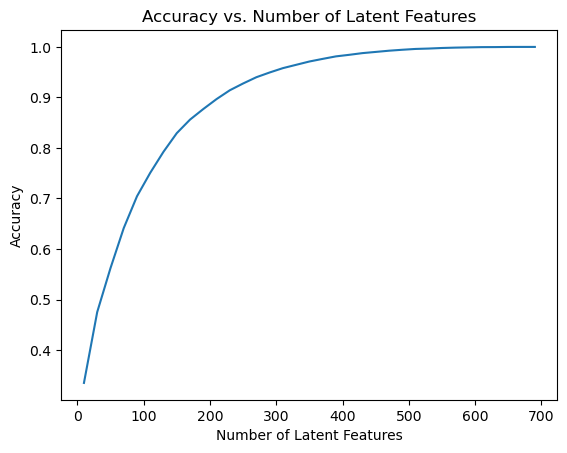

In [47]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs), axis=0), axis=0)
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [48]:
df_train = df.head(40000)
df_test = df.tail(5993)


def create_test_and_train_user_item(df_train, df_test):
    """
    INPUT:
    df_train - training dataframe
    df_test - test dataframe

    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids

    """
    # Your code here
    # Create user-item matrices for training and testing dataframes
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # Extract test indices and test articles
    test_idx = user_item_test.index.tolist()   # Convert index to list
    test_arts = user_item_test.columns.tolist()  # Convert columns to list

    return user_item_train, user_item_test, test_idx, test_arts


(
    user_item_train,
    user_item_test,
    test_idx,
    test_arts,
) = create_test_and_train_user_item(df_train, df_test)


In [49]:
print(f'user_item_train {user_item_train.shape}')
print(f'user_item_test {user_item_test.shape}')

user_item_train (4487, 714)
user_item_test (682, 574)


In [50]:
print(f'Users in the test set: {len(test_idx)}')

Users in the test set: 682


In [51]:
print(f"Articles can we make predictions: {len(set(user_item_train.columns) & set(test_arts))}")

Articles can we make predictions: 574


In [52]:
print(f"Users can we make predictions: {sum(user in test_idx for user in user_item_train.index)}")

Users can we make predictions: 20


In [53]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [54]:
# fit SVD on the user_item_train matrix
# fit svd similar to above then use the cells below
# SVD decomposition into U, S, VT matrices u_train, s_train, vt_train
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

# Filter common indexes and columns between train and test
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

In [55]:
print(f'train: {u_train.shape, vt_train.shape}')
print(f'test: {u_test.shape, vt_test.shape}')

train: ((4487, 4487), (714, 714))
test: ((20, 4487), (714, 574))


In [56]:
# Estimate ratings
def estimate_ratings(u_matrix, s_matrix, vt_matrix):
    """
    Estimate the user-item matrix from the truncated matrices obtained 
    from Singular Value Decomposition (SVD).

    Args:
        u_matrix (numpy.ndarray): Truncated U matrix of the user-item matrix.
        s_matrix (numpy.ndarray): Truncated diagonal matrix of singular values.
        vt_matrix (numpy.ndarray): Truncated VT matrix of the user-item matrix.

    Returns:
        numpy.ndarray: The estimated user-item matrix obtained by multiplying 
                       the truncated matrices and rounding to the nearest integer.
    """
    user_item_est = np.around(np.dot(np.dot(u_matrix, s_matrix), vt_matrix))
    return user_item_est


# Calculate the total error between the actual and the estimated
def calculate_error(real_data, estimated_data):
    """
    Calculate the total error between the actual and estimated user-item matrices.

    Args:
        real_data (numpy.ndarray): The actual user-item matrix with original values.
        estimated_data (numpy.ndarray): The estimated user-item matrix, typically obtained from SVD.

    Returns:
        float: The total sum of absolute differences between the actual and 
               estimated matrices across all elements.
    """
    diffs = np.subtract(real_data, estimated_data)
    diffs = np.sum(np.sum(np.abs(diffs), axis=0), axis=0)
    return diffs


# Calculate the accuracy
def calculate_accuracy(errors, total_elements):
    """
    Calculate the accuracy of the model by subtracting the normalized error from 1.

    Args:
        errors (list or numpy.ndarray): The list or array of errors for each latent feature.
        total_elements (int): The total number of elements in the user-item matrix (for normalization).

    Returns:
        numpy.ndarray: The accuracy values for each latent feature, calculated as (1 - normalized errors).
    """
    acc = 1 - (np.array(errors) / total_elements)
    return acc

In [57]:
# Initialize lists to store errors
train_errors = []
test_errors = []

# Feature range latent
latent_range = np.arange(10, 700 + 10, 20)

# Test subset based on common indexes
user_item_test = user_item_test.loc[
    list(set(user_item_train.index) & set(test_idx))
]

# Loop through the number of features latents
for i in latent_range:
    # Truncate U and VT test matrices
    new_s_train = np.diag(s_train[:i])
    new_u_train = u_train[:, :i]
    new_vt_train = vt_train[:i, :]

    # Estimate ratings for train and test
    user_item_train_est = estimate_ratings(
        new_u_train, new_s_train, new_vt_train
    )
    user_item_test_est = estimate_ratings(
        u_test[:, :i], new_s_train, vt_test[:i, :]
    )

    # Calculate errors for train and test
    train_err = calculate_error(user_item_train, user_item_train_est)
    test_err =  calculate_error(user_item_test, user_item_test_est)

    # Store errors
    train_errors.append(train_err)
    test_errors.append(test_err)

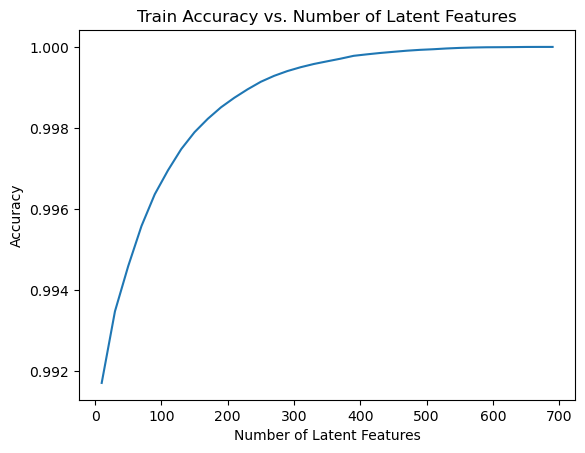

In [58]:
# Plot accuracy for train
train_accuracy = calculate_accuracy(
    train_errors, user_item_train.shape[0] * user_item_train.shape[1]
)

plt.plot(latent_range, train_accuracy)
plt.xlabel("Number of Latent Features")
plt.ylabel("Accuracy")
plt.title("Train Accuracy vs. Number of Latent Features")
plt.show()

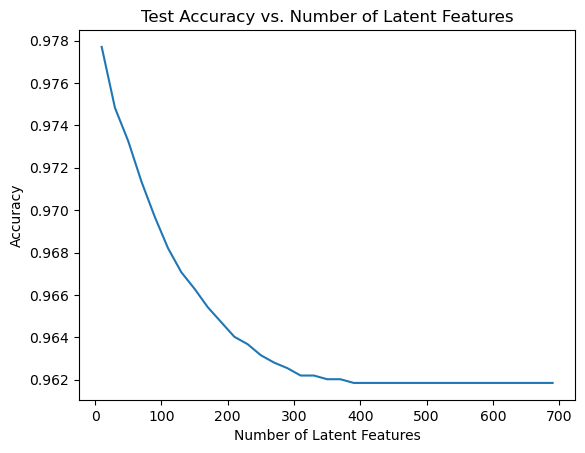

In [59]:
# Plot accuracy for test
test_accuracy = calculate_accuracy(
    test_errors,
    user_item_test.shape[0] * user_item_test.shape[1],
)

plt.plot(latent_range, test_accuracy)
plt.xlabel("Number of Latent Features")
plt.ylabel("Accuracy")
plt.title("Test Accuracy vs. Number of Latent Features")
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

This is a plot showing how the accuracy changes as the number of latent features increases. Ideally, we should observe that accuracy improves as more latent features are used, but at some point, it might start overfitting (i.e., the test accuracy may decrease). This visualization is crucial to finding an optimal number of latent features for our model.

In conclusion, the model's performance suggests that increasing latent features can lead to overfitting, as it performs well on training data but poorly on general predictions. Given the sparsity of the data, fewer latent features may be sufficient for accurate predictions. Due to the limited dataset and few overlaps between training and testing, relying solely on SVD for recommendations is not ideal. 

A hybrid approach, combining multiple recommendation methods and removing duplicates, could improve results, and A/B testing can help assess the system's effectiveness. 

Future improvements could include tracking user engagement metrics, like time spent on articles, and incorporating user feedback to fine-tune the model.

In [60]:
call(
    [
        "jupyter",
        "nbconvert",
        "--to",
        "html",
        "../src/Recommendations_with_IBM.ipynb",
    ]
)

[NbConvertApp] Converting notebook ../src/Recommendations_with_IBM.ipynb to html
[NbConvertApp] Writing 417954 bytes to ../src/Recommendations_with_IBM.html


0